Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

/home/simo/anaconda3/envs/pytorch_latest/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

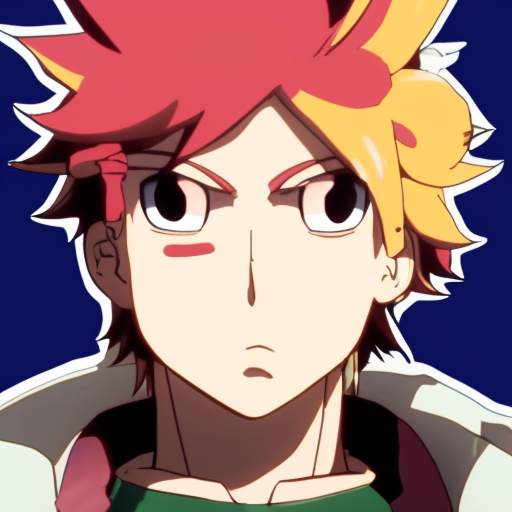

In [2]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch

model_id = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda:1"
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

prompt = "game character bnha"
torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]

image  # nice, but that's the base model.

  0%|          | 0/50 [00:00<?, ?it/s]

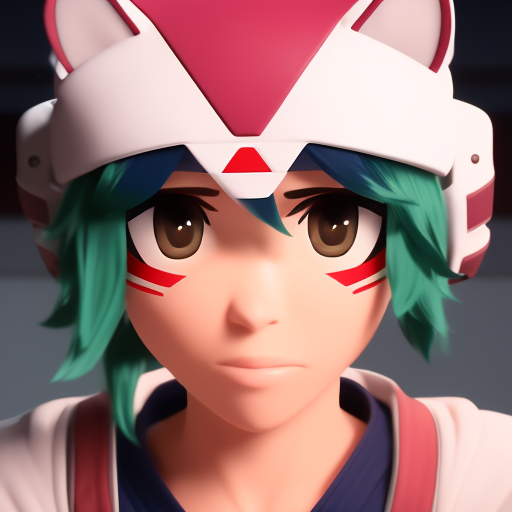

In [3]:
from lora_diffusion import monkeypatch_replace_lora, monkeypatch_lora, tune_lora_scale


monkeypatch_lora(pipe.unet, torch.load("../output_example_text/lora_weight_e55_s504.pt"))
monkeypatch_lora(pipe.text_encoder, torch.load("../output_example_text/lora_weight_e55_s504.text_encoder.pt"), target_replace_module=["CLIPAttention"])
tune_lora_scale(pipe.unet, 1.00)

torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image.save("../contents/lora_with_clip.jpg")
image # Wow ok, now I might have to deal with a

  0%|          | 0/50 [00:00<?, ?it/s]

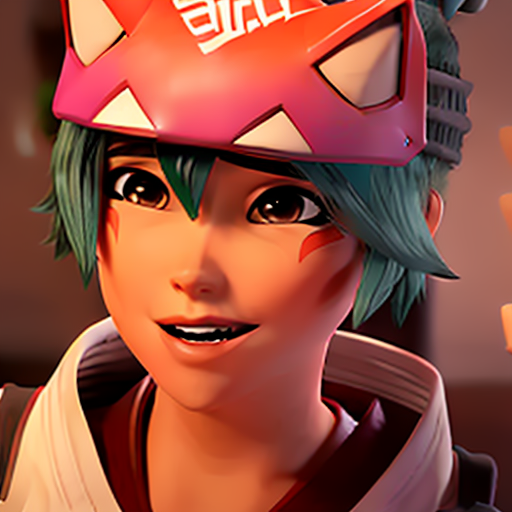

In [4]:

# this will replace current lora with new ones.
monkeypatch_replace_lora(pipe.unet, torch.load("../output_example_text/lora_weight_e1063_s9576.pt"))
monkeypatch_replace_lora(pipe.text_encoder, torch.load("../output_example_text/lora_weight_e1063_s9576.text_encoder.pt"), target_replace_module=["CLIPAttention"])
tune_lora_scale(pipe.unet, 1.00)

torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image

In [33]:
import glob
import os
alls = set(glob.glob("../output_example_text/lora_weight_*.pt"))
texts = set(glob.glob("../output_example_text/lora_weight_*.text_encoder.pt"))
unets = alls - texts

unets = list(unets)
unets.sort(key=os.path.getmtime)
texts = list(texts)
texts.sort(key=os.path.getmtime)

imgs = []
prompt = "female game character bnha, in a steampunk city, 4K render, trending on artstation, masterpiece"

for unet_lora, text_lora in zip(unets, texts):
    monkeypatch_replace_lora(pipe.unet, torch.load(unet_lora))
    monkeypatch_replace_lora(pipe.text_encoder, torch.load(text_lora), target_replace_module=["CLIPAttention"])
    
    tune_lora_scale(pipe.unet, 1.00)
    tune_lora_scale(pipe.text_encoder, 1.00)
    
    torch.manual_seed(6)
    image = pipe(prompt, num_inference_steps=40, guidance_scale=7).images[0]
    imgs.append(image)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [35]:
from PIL import Image

def image_grid(_imgs, rows, cols):
    assert len(_imgs) == rows*cols

    w, h = _imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(_imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid(imgs[:16], 4, 4).save("../contents/lora_with_clip_4x4_training_progress.jpg")

## What happens if we train both of them, and turn one off?

Let's find out:

  0%|          | 0/50 [00:00<?, ?it/s]

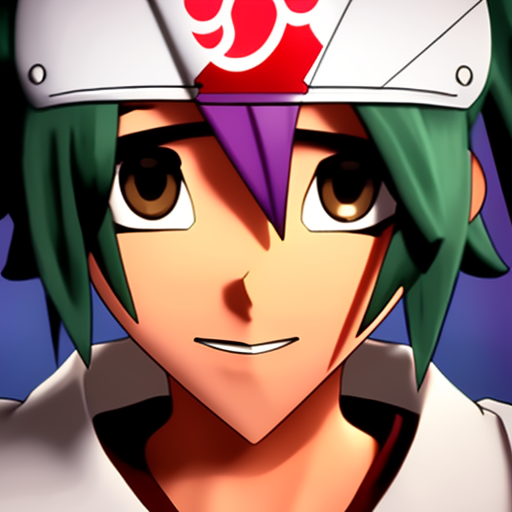

In [7]:
monkeypatch_replace_lora(pipe.unet, torch.load("../output_example_text/lora_weight_e503_s4536.pt"))
monkeypatch_replace_lora(pipe.text_encoder, torch.load("../output_example_text/lora_weight_e503_s4536.text_encoder.pt"), target_replace_module=["CLIPAttention"])
tune_lora_scale(pipe.unet, 1.00)
tune_lora_scale(pipe.text_encoder, 0.00)

torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image.save("../contents/lora_just_unet.jpg")
image

  0%|          | 0/50 [00:00<?, ?it/s]

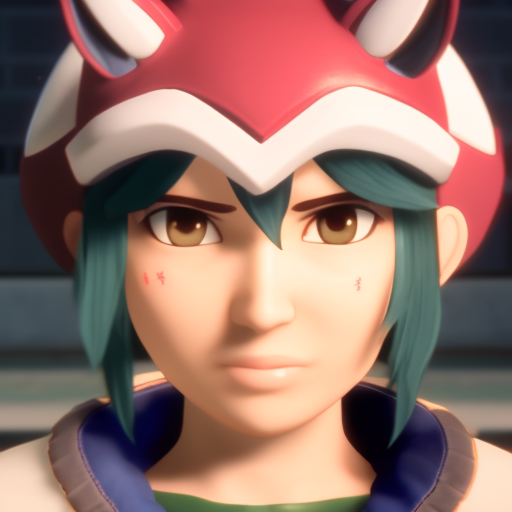

In [8]:
tune_lora_scale(pipe.unet, 0.00)
tune_lora_scale(pipe.text_encoder, 1.00)

torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image.save("../contents/lora_just_text_encoder.jpg")
image

So, entangled features were learnt from text encoder and unet.
They both learnt simillar semantics of the character, but they have learnt different geometric character. Interesting to see that 3d-ness was learnt by the encoder.